# Transformer using PyTorch
- 출처: [NN.TRANSFORMER 와 TORCHTEXT 로 시퀀스-투-시퀀스(SEQUENCE-TO-SEQUENCE) 모델링하기](https://tutorials.pytorch.kr/beginner/transformer_tutorial.html)

### Transformer 모듈이란?
* Attention is All You Need 논문에 기반
    * Transformer 모델은 더 높은 수준의 병렬화(parallelization)가 가능하면서도 많은 시퀀스-투-시퀀스 문제들에서 품질이 우수함이 입증되었습니다.
* nn.Transformer 모듈은 어텐션(attention) 메커니즘에 의존합니다.
    * 입력과 출력 사이의 전역적인 의존성(global dependencies) 을 나타내기 위하여 (?)
     * nn.Transformer 모듈은 현재 모듈화가 매우 잘 되어 있음
* 최근에 또 다른 모듈이 nn.MultiheadAttention 으로 구현

![image.png](https://tutorials.pytorch.kr/_images/transformer_architecture.jpg)

### Model의 정의
* Model: nn.TransformerEncoder
* Task: 언어 모델링(language modeling)
    * 언어 모델링 과제는 주어진 단어 (또는 단어의 시퀀스) 가 다음에 이어지는 단어 시퀀스를 따를 가능성(likelihood)에 대한 확률을 할당하는 것입니다. 먼저, 토큰(token) 들의 시퀀스가 임베딩(embedding) 레이어로 전달되며, 이어서 포지셔널 인코딩(positional encoding) 레이어가 각 단어의 순서를 설명합니다.
* nn.TransformerEncoder 는 여러 개의 nn.TransformerEncoderLayer 레이어로 구성되어 있습니다.
* nn.TransformerEncoder 내부의 셀프-어텐션(self-attention) 레이어들은 시퀀스 안에서의 이전 포지션에만 집중하도록 허용되기 때문에, 입력(input) 순서와 함께, 정사각 형태의 어텐션 마스크(attention mask) 가 필요합니다.
* 언어 모델링 과제를 위해서, 미래의 포지션에 있는 모든 토큰들은 마스킹 되어야(가려져야) 합니다.
* 실제 단어를 얻기 위해서, nn.TransformerEncoder 의 출력은 로그-소프트맥스(log-Softmax) 로 이어지는 최종 선형(Linear) 레이어로 전달 됩니다.

In [2]:
# Model Defnition
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerDecoderLayer

In [15]:
class TransformerModel(nn.Module):
    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, dropout=0.5):
        '''
        ntoken : 단어 사전의 크기
        ninp : 
        nhead : 멀티헤드 어텐션(multi-head attention) 모델의 헤드 개수
        nhid : nn.TransformerEncoder 에서 피드포워드 네트워크(feedforward network) 모델의 차원
        nlayers : nn.TransformerEncoder 내부의 nn.TransformerEncoderLayer 개수
        dropout : Dropout 값, 왜 같이 사용?
        '''
        super(TransformerModel, self).__init__()
        from torch.nn import TransformerEncoder, TransformerEncoderLayer
        self.model_type = 'Transformer'
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(ninp, dropout)
        encoder_layers = TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntoken, ninp)
        self.ninp = ninp
        self.decoder = nn.Linear(ninp, ntoken)

        self.init_weights()

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.encoder(src) * math.sqrt(self.ninp)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, self.src_mask)
        output = self.decoder(output)
        return output

PositionalEncoding 모듈은 시퀀스 안에서 토큰의 상대적인 또는 절대적인 포지션에 대한 어떤 정보를 주입합니다. 포지셔널 인코딩은 임베딩과 합칠 수 있도록 똑같은 차원을 가집니다. 여기에서, 우리는 다른 주파수(frequency) 의 sine 과 cosine 함수를 사용합니다.

In [16]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

### 데이터 로드하고 배치 만들기
학습 과정에서는 torchtext 의 Wikitext-2 데이터셋을 이용합니다. 단어 오브젝트는 훈련 데이터셋(train dataset) 에 의하여 만들어지고, 토큰을 텐서(tensor)로 수치화하는데 사용됩니다. 시퀀스 데이터로부터 시작하여, batchify() 함수는 데이터셋을 컬럼들로 배열하고, batch_size 사이즈의 배치들로 나눈 후에 남은 모든 토큰을 버립니다. 예를 들어, 알파벳을 시퀀스(총 길이 26) 로 생각하고 배치 사이즈를 4라고 한다면, 우리는 알파벳을 길이가 6인 4개의 시퀀스로 나눌 수 있습니다.

\begin{split}\begin{bmatrix}
\text{A} & \text{B} & \text{C} & \ldots & \text{X} & \text{Y} & \text{Z}
\end{bmatrix}
\Rightarrow
\begin{bmatrix}
\begin{bmatrix}\text{A} \\ \text{B} \\ \text{C} \\ \text{D} \\ \text{E} \\ \text{F}\end{bmatrix} &
\begin{bmatrix}\text{G} \\ \text{H} \\ \text{I} \\ \text{J} \\ \text{K} \\ \text{L}\end{bmatrix} &
\begin{bmatrix}\text{M} \\ \text{N} \\ \text{O} \\ \text{P} \\ \text{Q} \\ \text{R}\end{bmatrix} &
\begin{bmatrix}\text{S} \\ \text{T} \\ \text{U} \\ \text{V} \\ \text{W} \\ \text{X}\end{bmatrix}
\end{bmatrix}\end{split}

이 컬럼들은 모델에 의해서 독립적으로 취급되며, 이것은 더 효율적인 배치 프로세싱(batch processing) 이 가능하지만, `G` 와 `F` 의 의존성이 학습될 수 없다는 것을 의미합니다.

In [17]:
import torchtext
from torchtext.data.utils import get_tokenizer

TEXT = torchtext.data.Field(tokenize=get_tokenizer("basic_english"),
                            init_token='<sos>',
                            eos_token='<eos>',
                            lower=True)
train_txt, val_txt, test_txt = torchtext.datasets.WikiText2.splits(TEXT)
TEXT.build_vocab(train_txt)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
def batchify(data, bsz):
    '''
    bsz : batch_size
    '''
    data = TEXT.numericalize([data.examples[0].text])
    # 데이터셋을 bsz 파트들로 나눕니다.
    nbatch = data.size(0) // bsz
    # 깔끔하게 나누어 떨어지지 않는 추가적인 부분(나머지들) 은 잘라냅니다.
    data = data.narrow(0, 0, nbatch * bsz)
    # 데이터에 대하여 bsz 배치들로 동등하게 나눕니다.
    data = data.view(bsz, -1).t().contiguous()
    return data.to(device)

batch_size = 20
eval_batch_size = 10
train_data = batchify(train_txt, batch_size)
val_data = batchify(val_txt, eval_batch_size)
test_data = batchify(test_txt, eval_batch_size)

### 입력(input) 과 타겟(target) 시퀀스를 생성하기 위한 함수들
get_batch() 함수는 트랜스포머 모델을 위한 입력과 타겟 시퀀스를 생성합니다. 이 함수는 소스 데이터를 bptt 길이를 가진 덩어리로 세분화 합니다. 언어 모델링 과제를 위해서, 모델은 다음 단어인 Target 이 필요 합니다. 예를 들어, bptt 의 값이 2 라면, 우리는 i = 0 일 때 다음의 2 개의 변수(Variable) 를 얻을 수 있습니다:

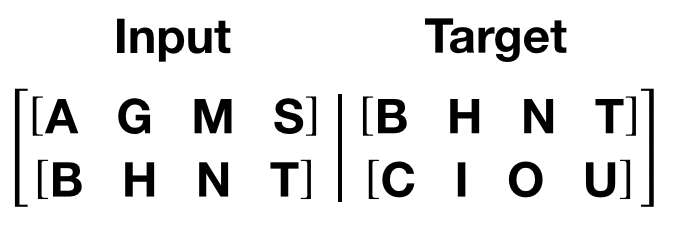

변수 덩어리는 트랜스포머 모델의 S 차원과 일치하는 0 차원에 해당합니다. 배치 차원 N 은 1 차원에 해당합니다.

In [19]:
bptt = 35
def get_batch(source, i):
    seq_len = min(bptt, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].view(-1)
    return data, target

### 인스턴스(instance) 초기화하기
모델은 아래와 같은 하이퍼파라미터(hyperparameter) 로 세팅 됩니다. 단어 사이즈는 단어 오브젝트의 길이와 일치 합니다.

In [20]:
ntokens = len(TEXT.vocab.stoi) # 단어 사전의 크기
emsize = 200 # 임베딩 차원
nhid = 200 # nn.TransformerEncoder 에서 피드포워드 네트워크(feedforward network) 모델의 차원
nlayers = 2 # nn.TransformerEncoder 내부의 nn.TransformerEncoderLayer 개수
nhead = 2 # 멀티헤드 어텐션(multi-head attention) 모델의 헤드 개수
dropout = 0.2 # 드랍아웃(dropout) 값
model = TransformerModel(ntokens, emsize, nhead, nhid, nlayers, dropout).to(device)

### 모델 실행하기
손실(loss) 을 추적하는 데에는 CrossEntropyLoss 가 적용되며, 옵티마이저(optimizer) 로서 SGD 는 확률적 경사 하강법(stochastic gradient descent method) 을 구현합니다. 초기 학습률(learning rate) 은 5.0 으로 설정됩니다. StepLR 은 에포크(epoch) 에 따라서 학습률을 조절하는데 사용됩니다. 학습하는 동안에, 우리는 기울기 폭발(gradient exploding) 을 방지하기 위하여 모든 기울기를 함께 스케일(scale) 하는 함수인 nn.utils.clip_grad_norm_ 을 이용합니다.

In [21]:
criterion = nn.CrossEntropyLoss()
lr = 5.0 # 학습률
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

import time
def train():
    model.train() # 학습 모드를 시작합니다.
    total_loss = 0.
    start_time = time.time()
    ntokens = len(TEXT.vocab.stoi)
    for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt)):
        data, targets = get_batch(train_data, i)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output.view(-1, ntokens), targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        log_interval = 200
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.2f} | ms/batch {:5.2f} | '
                  'loss {:5.2f} | ppl {:8.2f}'.format(
                    epoch, batch, len(train_data) // bptt, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()

def evaluate(eval_model, data_source):
    eval_model.eval() # 평가 모드를 시작합니다.
    total_loss = 0.
    ntokens = len(TEXT.vocab.stoi)
    with torch.no_grad():
        for i in range(0, data_source.size(0) - 1, bptt):
            data, targets = get_batch(data_source, i)
            output = eval_model(data)
            output_flat = output.view(-1, ntokens)
            total_loss += len(data) * criterion(output_flat, targets).item()
    return total_loss / (len(data_source) - 1)

에포크 내에서 반복됩니다. 만약 검증 오차(validation loss) 가 우리가 지금까지 관찰한 것 중 최적이라면 모델을 저장합니다. 매 에포크 이후에 학습률을 조절합니다.

In [ ]:
best_val_loss = float("inf")
epochs = 3 # 에포크 수
best_model = None

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train()
    val_loss = evaluate(model, val_data)
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} | '
          'valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                     val_loss, math.exp(val_loss)))
    print('-' * 89)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model

    scheduler.step()

### 평가 데이터셋(test dataset) 으로 모델을 평가하기
평가 데이터셋에 대한 결과를 확인하기 위해서 최고의 모델을 적용합니다.

In [ ]:
test_loss = evaluate(best_model, test_data)
print('=' * 89)
print('| End of training | test loss {:5.2f} | test ppl {:8.2f}'.format(
    test_loss, math.exp(test_loss)))
print('=' * 89)